In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import ast
import matplotlib.pyplot as plt

In [2]:
scene_events_df = pd.read_csv('tut18_feat_ablation_sceneXevents_0.csv')

for i, row in scene_events_df.iterrows():
    row['feat_ablation_preds'] = ast.literal_eval(row['feat_ablation_preds'])
    row['scene_events'] = ast.literal_eval(row['scene_events'])
    row['feat_ablation_events'] = ast.literal_eval(row['feat_ablation_events'])

In [3]:
scapper_scenes = scene_events_df['acoustic_scene_label'].unique()
feat_ablation_scene_preds = {scene:[0 for i in range(16)] for scene in scapper_scenes}

for i, row in scene_events_df.iterrows():
    scene = row['acoustic_scene_label']
    #print(row['feat_ablation_preds'])
    for j in range(len(row['feat_ablation_preds'])):
        if scene != row['feat_ablation_preds'][j]:
            feat_ablation_scene_preds[scene][j] += 1

In [4]:
feat_ablation_indices = {scene:[] for scene in scapper_scenes}

for scene in scapper_scenes:
    feat_ablation_indices[scene] = [i for i in range(len(feat_ablation_scene_preds[scene])) if feat_ablation_scene_preds[scene][i] >= 15]

In [5]:
import collections

all_events = set()

for i, row in scene_events_df.iterrows():
    for j in row['feat_ablation_events']:
        for k in range(len(j)):
            all_events.add(j[k])

for i, row in scene_events_df.iterrows():
    for j in row['scene_events']:
        all_events.add(j)

scene_wise_event_counts = collections.defaultdict(dict)
for scene in scapper_scenes:
    scene_wise_event_counts[scene] = collections.defaultdict(dict)
    for i in (list)(all_events):
        scene_wise_event_counts[scene][i] = 0
    for j in scene_events_df[scene_events_df['acoustic_scene_label']==scene]['scene_events']:
        for k in range(len(j)):
            #print(k)
            scene_wise_event_counts[scene][j[k]] += 1

In [6]:
for scene in scapper_scenes:
    scene_wise_event_counts[scene] = sorted(scene_wise_event_counts[scene].items(), key=lambda item: item[1], reverse=True)

In [7]:
events_freq = {event:0 for event in all_events}

for i in scene_events_df['scene_events']:
    for j in i:
        events_freq[j] += 1

events_freq = sorted(events_freq.items(), key=lambda item: item[1], reverse=True)

In [20]:
'''scapper_scenes - all scenes
all_events - all events
scene_events_df - acoustic_scene_label, audio_fname, feat_ablation_preds, scene_events, feat_ablation_events
events_freq - frequency of all the events present in all the scenes
scene_wise_event_counts - count of each event in each scene
feat_ablation_indices - indices of feat columns that when ablated, changes the preds (indices of important features found after feature ablation)
'''

'scapper_scenes - all scenes\nall_events - all events\nscene_events_df - acoustic_scene_label, audio_fname, feat_ablation_preds, scene_events, feat_ablation_events\nevents_freq - frequency of all the events present in all the scenes\nscene_wise_event_counts - count of each event in each scene\nfeat_ablation_indices - indices of feat columns that when ablated, changes the preds (indices of important features found after feature ablation)\n'

In [8]:
from collections import defaultdict

diff_events_dict = defaultdict(dict)

for scene in scapper_scenes:
    diff_events_dict[scene] = defaultdict(dict)
    for indices in feat_ablation_indices[scene]:
        diff_events_dict[scene][indices] = {i:0 for i in (list)(all_events)}
        #print(scene, indices)

for i, row in scene_events_df.iterrows():
    scene = row['acoustic_scene_label']
    tru_events = row['scene_events']
    pred_events = row['feat_ablation_events']
    #print(scene, len(pred_events))
    for j in range(len(pred_events)):
        seti = set(pred_events[j])
        setj = set(tru_events)
        diff_list = list(seti.symmetric_difference(setj))
        for k in diff_list:
            ind = feat_ablation_indices[scene][j]
            #print(scene, ind, k)
            diff_events_dict[scene][ind][k] += 1

for scene in scapper_scenes:
    for indices in feat_ablation_indices[scene]:
        diff_events_dict[scene][indices] = sorted(diff_events_dict[scene][indices].items(), key=lambda item: item[1], reverse=True)   

In [9]:
events_based_on_freq = defaultdict(dict)
events_based_on_scene = defaultdict(dict)

for scene in scapper_scenes:
    events_based_on_scene[scene] = defaultdict(dict)
    for i in feat_ablation_indices[scene]:
        events_based_on_freq[i] = defaultdict(dict)
        for j in (list)(all_events):
            events_based_on_freq[i][j] = 0
    for k in (list)(all_events):
        events_based_on_scene[scene][k] = 0

In [10]:
for i, row in scene_events_df.iterrows():
    scene = row['acoustic_scene_label']
    tru_events = row['scene_events']
    pred_events = row['feat_ablation_events']
    for j in range(len(pred_events)):
        seti = set(pred_events[j])
        setj = set(tru_events)
        diff_list = list(seti.symmetric_difference(setj))
        
        if len(diff_list) > 0:
            for k in diff_list:
                ind = feat_ablation_indices[scene][j]
                events_based_on_freq[ind][k] += 1
                events_based_on_scene[scene][k] += 1

In [11]:
for scene in scapper_scenes:
    events_based_on_scene[scene] = sorted(events_based_on_scene[scene].items(), key=lambda item: item[1], reverse=True)

for indices in events_based_on_freq:
    events_based_on_freq[indices] = sorted(events_based_on_freq[indices].items(), key=lambda item: item[1], reverse=True)

In [13]:
import json
audioset_ontology_df = pd.read_json('audioset_ontology.json')
# name: event_label
# id: id of the current id
# child_ids: list of child event ids

def get_event_ids(event_id):
    idx = audioset_ontology_df[audioset_ontology_df['child_ids'].apply(lambda x: event_id in x)]
    if len(idx) > 0:
        return idx['id'].iloc[0]
    else:
        return 'None'
    
def get_immediate_parent_class_label(event_label):
    event_row = audioset_ontology_df.loc[audioset_ontology_df['name']==event_label]
    event_id = event_row['id'].to_string(index=False)
    parent_event_id = get_event_ids(event_id)
    parent_class_label = audioset_ontology_df[audioset_ontology_df['id']==parent_event_id]['name'].to_string(index=False)
    if parent_event_id == 'None':
        return 'None'
    else:
        return parent_class_label

def get_parent_class_label(event_label):
    event_row = audioset_ontology_df.loc[audioset_ontology_df['name']==event_label]
    event_id = event_row['id'].to_string(index=False)
    parent_event_id = get_event_ids(event_id)
    while get_event_ids(parent_event_id) != 'None':
        parent_event_id = get_event_ids(parent_event_id)
    parent_class_label = audioset_ontology_df[audioset_ontology_df['id']==parent_event_id]['name'].to_string(index=False)
    if parent_event_id == 'None':
        return 'None'
    else:
        return parent_class_label

all_parent_events = set()
for event in list(all_events):
    if get_parent_class_label(event) == 'None':
        all_parent_events.add(event)
    else:
        all_parent_events.add(get_parent_class_label(event))

In [87]:
get_immediate_parent_class_label('Chatter')

'Human group actions'

In [20]:
all_plural = defaultdict(dict)

for scene in scapper_scenes:
    all_plural[scene] = []
    for event in (events_based_on_scene[scene]):
        if (event[1])>2:
            all_plural[scene].append(event[0])

In [16]:
get_parent_class_label('Fire'), get_immediate_parent_class_label('Radio')

('Natural sounds', 'Sound reproduction')

In [14]:
final_event_list = ['Music', 'Inside, small room', 'Vehicle', 'Telephone', 'Human sounds', 'Ringtone', 'Bird', 'Telephone', 'Speech', 'Alarm', 'Animal',
 'Domestic sounds, home sounds', 'Children playing', 'Motor vehicle (road)', 'Door', 'Rail transport', 'Outside, urban or manmade', 'Car',
 'Alarm', 'Clock', 'Typing', 'Inside, small room', 'Human locomotion', 'Outside, rural or natural', 'Television', 'Glass', 'Radio',
 'Environmental noise', 'Source-ambiguous sounds', 'Mechanisms', 'Water', 'Sounds of things', 'Inside, large room or hall']

final_event_count = defaultdict(dict)

for scene in scapper_scenes:
    for i in final_event_list:
        final_event_count[scene][i] = 0

In [15]:
for scene in events_based_on_scene:
    for i in events_based_on_scene[scene]:
        event_ = i[0]
        print(i)
        while event_ not in final_event_list:
            event_ = get_immediate_parent_class_label(event_)
        final_event_count[scene][event_] += i[1]
        #print(event_, i[1])

('Vehicle', 73)
('Horse', 62)
('Patter', 48)
('Clip-clop', 47)
('Run', 45)
('Animal', 39)
('Outside, urban or manmade', 34)
('Typing', 21)
('Neigh, whinny', 21)
('Computer keyboard', 19)
('Bird', 18)
('Mouse', 14)
('Tick-tock', 9)
('Pigeon, dove', 8)
('Rodents, rats, mice', 7)
('Speech', 6)
('Squish', 5)
('Clicking', 4)
('Tick', 4)
('Duck', 4)
('Quack', 3)
('Bicycle', 3)
('Music', 2)
('Chink, clink', 2)
('Sliding door', 2)
('Domestic animals, pets', 2)
('Outside, rural or natural', 1)
('Silence', 1)
('Goose', 1)
('Glass', 1)
('Typewriter', 1)
('Drip', 1)
('Dog', 1)
('Fowl', 1)
('Honk', 1)
('Musical instrument', 0)
('Singing bowl', 0)
('Chirp, tweet', 0)
('Snake', 0)
('Car passing by', 0)
('Mechanisms', 0)
('Train', 0)
('Turkey', 0)
('Car', 0)
('Engine', 0)
('Aircraft', 0)
('Engine knocking', 0)
('Railroad car, train wagon', 0)
('Telephone dialing, DTMF', 0)
('Rain', 0)
('Hoot', 0)
('Sailboat, sailing ship', 0)
('Insect', 0)
('Heart sounds, heartbeat', 0)
('Propeller, airscrew', 0)
('To

KeyboardInterrupt: 

<Axes: >

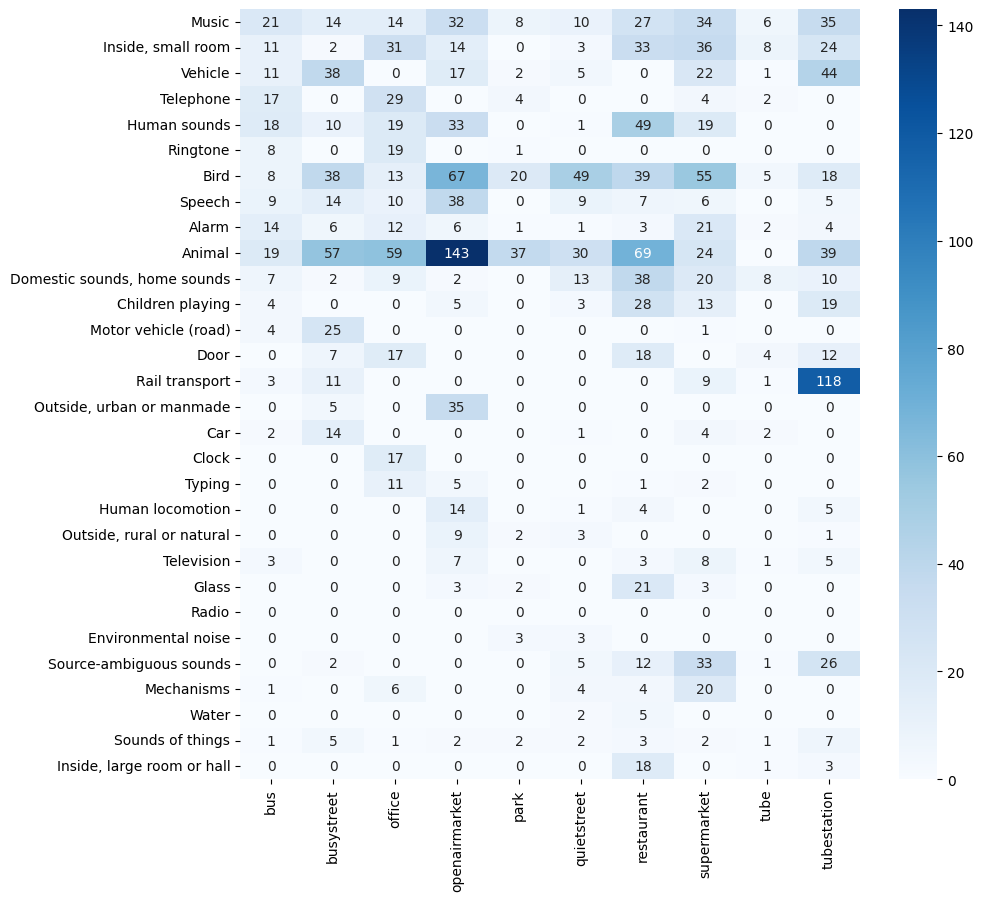

In [107]:
plt.figure(figsize=(10, 10))
sns.heatmap(pd.DataFrame(final_event_count), annot=True, cmap='Blues', fmt='d')

In [69]:
scene = scapper_scenes[9]
print(scene)
for i in all_plural[scene]:
    event_row = audioset_ontology_df.loc[audioset_ontology_df['name']==i]
    event_id = event_row['id'].to_string(index=False)
    parent_event_id = get_event_ids(event_id)
    
    print(i, '\t', audioset_ontology_df[audioset_ontology_df['id']==parent_event_id]['name'].to_string(index=False))

tubestation
Train 	 Rail transport
Vehicle 	 Sounds of things
Music 	 Series([], )
Rail transport 	 Vehicle
Inside, small room 	 Acoustic environment
Children playing 	 Human group actions
Railroad car, train wagon 	 Rail transport
Subway, metro, underground 	 Rail transport
Animal 	 Series([], )
Crunch 	 Onomatopoeia
Sliding door 	 Door
Cupboard open or close 	 Domestic sounds, home sounds
Bird 	 Wild animals
Crumpling, crinkling 	 Deformable shell
Pigeon, dove 	 Bird
Arrow 	 Miscellaneous sources
Train wheels squealing 	 Rail transport
Television 	 Sound reproduction
Walk, footsteps 	 Human locomotion
Dog 	 Domestic animals, pets
Horse 	 Livestock, farm animals, working animals
Mouse 	 Rodents, rats, mice
Insect 	 Wild animals
Smoke detector, smoke alarm 	 Alarm
Clickety-clack 	 Clicking
Snake 	 Wild animals
Cat 	 Domestic animals, pets
Inside, large room or hall 	 Acoustic environment
Child speech, kid speaking 	 Speech


In [255]:
scene_parent_eventClass_count = defaultdict(dict)

for scene in scapper_scenes:
    scene_parent_eventClass_count[scene] = defaultdict(dict)
    for i in (list)(all_parent_events):
        scene_parent_eventClass_count[scene][i] = 0

for scene in events_based_on_scene:
    for i in events_based_on_scene[scene]:
        parent_class = get_parent_class_label(i[0])
        if parent_class != 'None':
            scene_parent_eventClass_count[scene][parent_class] += i[1]
        else:
            scene_parent_eventClass_count[scene][i[0]] += i[1]

In [256]:
pd.DataFrame(scene_parent_eventClass_count)
#scene_parent_eventClass_count_df.drop(scene_parent_eventClass_count_df.tail(1).index, inplace=True)

,bus,busystreet,office,openairmarket,park,quietstreet,restaurant,supermarket,tube,tubestation
Source-ambiguous sounds,0,2,0,0,0,5,12,33,1,26
Music,21,14,14,32,8,10,27,34,6,35
Animal,27,95,72,210,57,79,108,79,5,57
Sounds of things,68,108,121,35,12,26,88,108,21,195
Natural sounds,0,0,0,0,0,2,5,0,0,0
Human sounds,31,24,29,90,0,14,88,38,0,29
"Channel, environment and background",14,7,31,65,5,9,54,44,10,33


<Axes: >

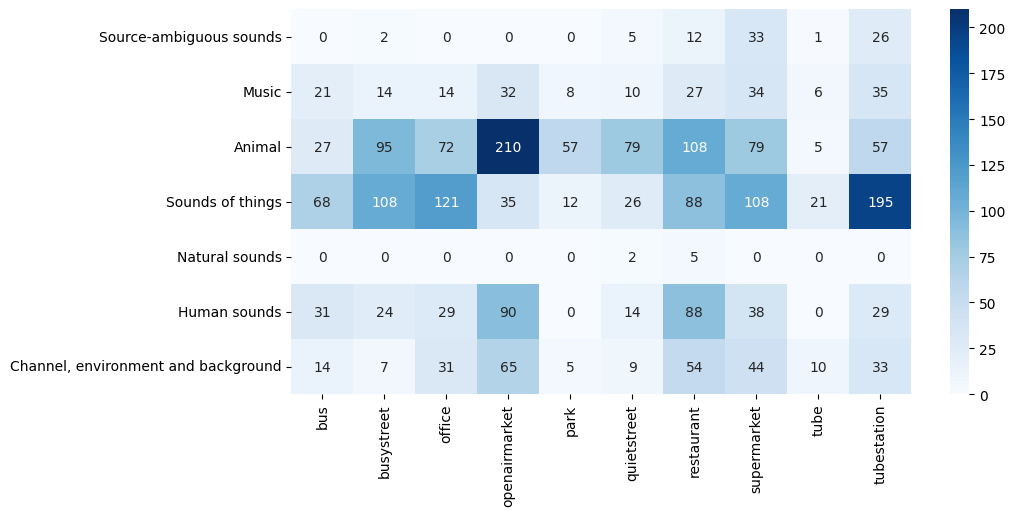

In [257]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.heatmap(pd.DataFrame(scene_parent_eventClass_count), annot=True, cmap='Blues', fmt='d')

<Axes: >

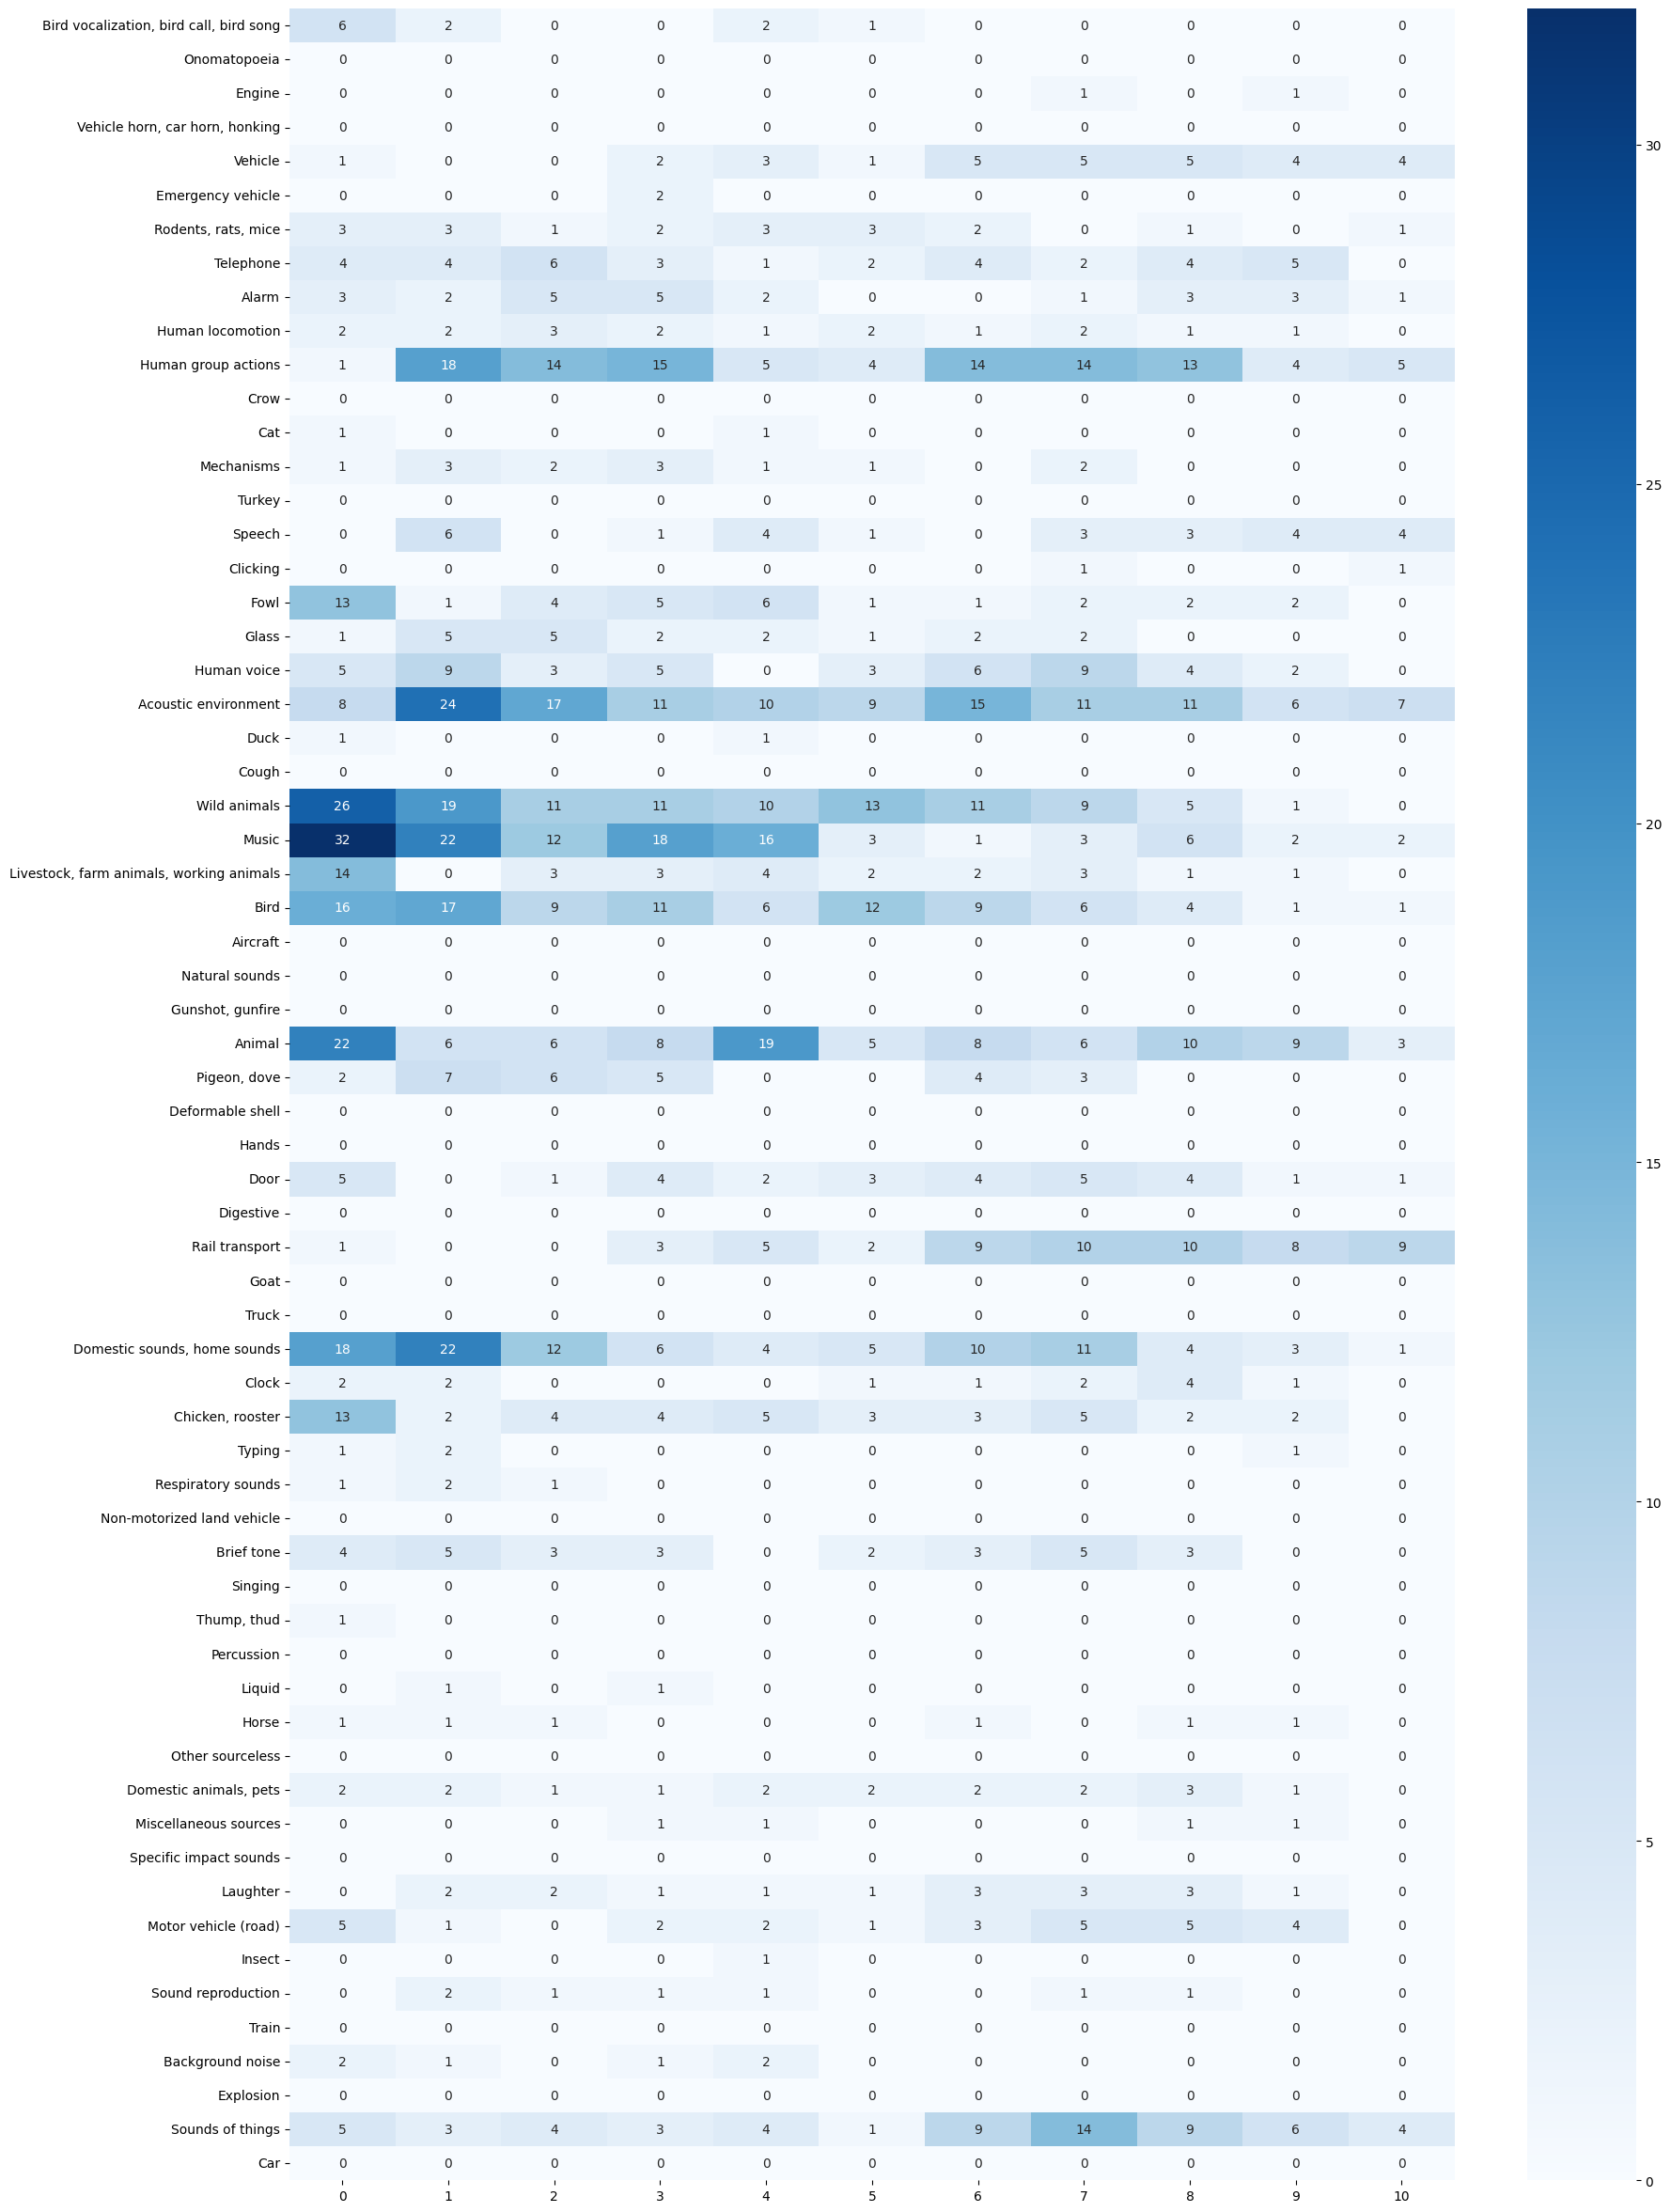

In [165]:
freq_parent_eventClass_count = defaultdict(dict)

for i in events_based_on_freq:
    freq_parent_eventClass_count[i] = defaultdict(dict)
    for j in (list)(all_parent_events):
        freq_parent_eventClass_count[i][j] = 0

for i in events_based_on_freq:
    for j in events_based_on_freq[i]:
        parent_class = get_parent_eventClass(j[0])
        if parent_class != 'None':
            freq_parent_eventClass_count[i][parent_class] += j[1]
        else:
            freq_parent_eventClass_count[i][j[0]] += j[1]

plt.figure(figsize=(20, 30))
sns.heatmap(pd.DataFrame(freq_parent_eventClass_count), annot=True, cmap='Blues')

In [48]:
missed_event_0 = set()

for i, row in scene_events_df[scene_events_df['acoustic_scene_label']=='busystreet'].iterrows():
    tru_ = row['scene_events']
    pred_ = row['feat_ablation_events'][1]
    for j in range(len(tru_)):
        if tru_[j] not in pred_:
            missed_event_0.add(tru_[j])

In [76]:
import collections

d = collections.defaultdict(dict)

for scene in scapper_scenes:
    d[scene] = {i:0 for i in (list)(all_events)}


SyntaxError: invalid syntax (4217839361.py, line 6)

In [1]:
import pandas as pd
import numpy as np
import librosa
import panns_inference
from panns_inference import AudioTagging, SoundEventDetection, labels
import torch

import sys
sys.path.append("../ASC_AED_JoinTask/Datasets/")

import datasets

In [3]:
def string_to_list(events_string):
    if events_string == '[]':
        return []
    else:
        return_list = events_string[1:-1].split("', '")
        return_list[0] = return_list[0].split("'")[1]
        return_list[-1] = return_list[-1].split("'")[0]
        return return_list

In [4]:
scapper_df = pd.read_csv('../ASC_AED_JoinTask/predictions/scapper_preds/scrapper_test_panns_eventsInference.csv')
pred_events_col = 'scrapper_panns_inference_events_list'

In [5]:
scapper_df[pred_events_col].iloc[0]

"['Speech', 'Telephone bell ringing', 'Telephone', 'Music', 'Vehicle', 'Alarm clock', 'Inside, small room', 'Laughter', 'Giggle']"

In [6]:
all_events = set()

for index, row in enumerate(scapper_df[pred_events_col]):
    #print(row)
    event_list = string_to_list(row)
    for event in event_list:
        all_events.add(event)

In [7]:
import math

new_events_df = pd.DataFrame(index=(list)(all_events), columns=scapper_df['acoustic_scene_label'].unique())

for index, row in scapper_df.iterrows():
    #print(row['acoustic_scene_label'], row[pred_events_col])
    for i in string_to_list(row[pred_events_col]):
        if math.isnan(new_events_df[row['acoustic_scene_label']][i]):
            new_events_df[row['acoustic_scene_label']][i] = 0
        new_events_df[row['acoustic_scene_label']][i] += 1

new_events_df = new_events_df.fillna(0)

In [8]:
import seaborn as sns

scene_events_dict = {}

for scene in new_events_df.columns:
    scene_events_dict[scene] = new_events_df[scene][new_events_df[scene] > 0].sort_values(ascending=False)

/work/dpandya/miniconda3/envs/noiseremoval/lib/python3.11/site-packages/librosa/feature/spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


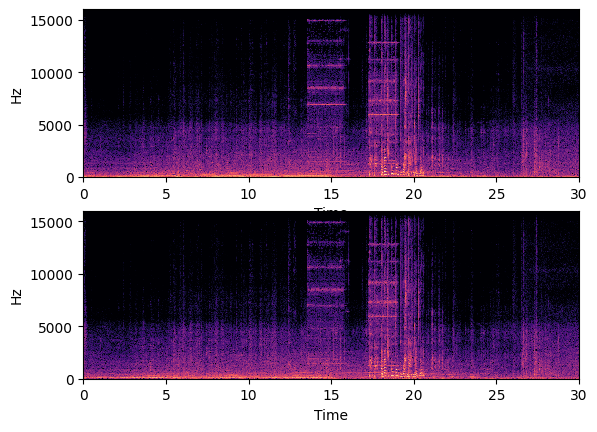

In [9]:
import panns_inference
import sys
import librosa
import os
sys.path.append("../ASC_AED_JoinTask/Datasets/")
import datasets
import audio_utils as au
from IPython.display import display, Audio
import torchaudio
import torchaudio.transforms as T
import matplotlib.pyplot as plt
#model_path00 = '../ASC_AED_JoinTask/models/Cnn14_mAP=0.431.pth'

sample = os.path.join(datasets.SCAPPER_AUD_DIR + 'test/', scapper_df['audio_fileNames'].iloc[0]) 
audio = au.load_audio_from_file(sample, sample_rate=au.SAMPLE_RATE)
#audio, sr = torchaudio.load(sample)
stf = librosa.stft(audio, n_fft=au.N_FFT, hop_length=au.HOP_LEN)
new = librosa.power_to_db(np.abs(stf)**2, ref=np.max)
log_mel = au.get_log_melSpectrogram(audio, n_fft=au.N_FFT, hop_len=au.HOP_LEN, n_mels=641)

plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(stf), ref=np.max), y_axis='linear', x_axis='time', sr=au.SAMPLE_RATE, hop_length=au.HOP_LEN, n_fft=au.N_FFT)
plt.subplot(2, 1, 2)
librosa.display.specshow(new, sr=au.SAMPLE_RATE, hop_length=au.HOP_LEN, x_axis='time', y_axis='linear', n_fft=au.N_FFT)
#display(Audio(audio, rate=au.SAMPLE_RATE))


In [121]:
(stf == log_mel.squeeze().numpy()).sum()

0

In [106]:
spec.shape

(257, 5168)